# Cross Validation of NMF

Perform cross-validation for NMF.

In [1]:
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path
import os

sns.set("talk", "ticks", palette='colorblind')

# Set the default paths
basepath = Path(os.path.dirname(os.path.realpath('__file__')))
datapath = basepath.parent.joinpath('data/munged')

print (datapath)

/Users/laurayang/Dropbox/Dr.Ng Group/Yang/Project2-LCS/B_Code-ES&T Roof/data/munged


## Write the Nonnegative Matrix Factorization Code that can handle missing data

In [2]:
from nonnegfac.nnls import nnlsm_blockpivot as nnlstsq

def censored_nnlstsq(A, B, M):
    """Solves nonnegative least-squares problem with missing data in B
    Args
    ----
    A (ndarray) : m x r matrix
    B (ndarray) : m x n matrix
    M (ndarray) : m x n binary matrix (zeros indicate missing values)
    
    Returns
    -------
    X (ndarray) : nonnegative r x n matrix that minimizes norm(M*(AX - B))
    """
    if A.ndim == 1:
        A = A[:, None]
        
    rhs = np.dot(A.T, M * B).T[:, :, None] # n x r x 1 tensor
    T = np.matmul(A.T[None,:,:], M.T[:,:,None] * A[None,:,:]) # n x r x r tensor
    X = np.empty((B.shape[1], A.shape[1]))
    
    for n in range(B.shape[1]):
        X[n] = nnlstsq(T[n], rhs[n], is_input_prod=True)[0].T
    
    return X.T

def cv_nmf(data, rank, M=None, p_holdout=0.3, tol=0.001, verbose=False, max_iter=50):
    """Perform cross-validation for NMF using a speckled holdout pattern.
    
    This code was adapted from Alex Williams at Stanford (https://bit.ly/2KDqKoW).
    
    Args
    ----
    data (ndarray)    : m x n matrix (original data/time-series)
    rank (int)        : the desired output rank (i.e. number of factors)
    M (ndarray)       : m x n binary matrix where zeroes indicate missing/heldout values 
    p_holdout (float) : all random data under this value will be set to False
    tol (float)       : the tolerance for convergence - the solution has converged when 
                        the MSE of subsequent iterations are less than this number
    verbose (bool)    : if True, print out debugging information
    max_itr (int)     : the maximum number of iterations for convergence
    
    Returns
    -------
    U (ndarray)       : 
    Vt (ndarray)      :
    train_err (float) :
    test_err (float)  :
    converged (bool)  :
    
    """   
    # create the masking matrix to decide which values to "hold out"
    if M is None:
        M = np.random.rand(*data.shape) > p_holdout
        
        # check to make sure there are enough values in each row to avoid singular matrix issues
        if M.sum(axis=0).any() < rank:
            for i in range(M.shape[0]):
                if M[i].sum() < rank:
                    M[i, :] = [True]*M.shape[1]
    
    # initialize U randomly
    U = np.random.rand(data.shape[0], rank)

    # init the mean err
    mse = 100
    
    # fit NMF
    for itr in range(max_iter):
        Vt = censored_nnlstsq(U, data, M)
        U = censored_nnlstsq(Vt.T, data.T, M.T).T
        
        # calculate the current iterations mean squared error
        tmp_mse = np.mean((np.dot(U, Vt) - data)**2)
        diff = mse - tmp_mse
          
        # break out of the loop if converged
        if abs(diff) <= tol:
            converged = True
            break
        else:
            mse = tmp_mse
            converged = False
    
    if verbose:
        train_pct = 100 * M.sum() / M.size
        print ("\tIter {} = {:.5f}".format(itr+1, diff))
        print ("\tTrain/Test = {:.2f}/{:.2f}".format(train_pct, 100-train_pct))
        
    # return the result and the train/test error
    resid = np.dot(U, Vt) - data
    train_err = np.mean(resid[M]**2)
    test_err = np.mean(resid[~M]**2)
        
    return U, Vt, train_err, test_err, converged

### Let's try an example...

In [3]:
N, R = 150, 4

noise = 0.8
replicates = 10

ranks = np.arange(1, 8)

# initialize the problem
U = np.random.rand(N, R) # (150, 4)
Vt = np.random.rand(R, N) # (4, 150)

# create the data by making it noisy
data = np.dot(U, Vt) + noise * np.random.rand(N, N) # (150, 150)

frame = pd.DataFrame()

# fit the models
for rnk, _ in itertools.product(ranks, range(replicates)):
    tr, te, converged = cv_nmf(data, rnk, verbose=False)[2:]
    
    if converged:
        frame = frame.append([
            {"Rank": rnk, "MSE": tr, "Group": "Train"},
            {"Rank": rnk, "MSE": te, "Group": "Test"},
        ], ignore_index=True)
    else:
        print ("there was a convergence issue: {}".format(rnk))
        
frame["Rank"] = frame["Rank"].astype(np.int32)

# prepare for plotting
groups = frame.groupby(["Group", "Rank"]).describe(percentiles=[0.05, 0.95])

In [4]:
groups

MSE                                                              \
           count      mean       std       min        5%       50%       95%   
Group Rank                                                                     
Test  1     10.0  0.077875  0.001231  0.075952  0.076300  0.077622  0.079828   
      2     10.0  0.071809  0.000686  0.070337  0.070841  0.071832  0.072681   
      3     10.0  0.065631  0.000706  0.064535  0.064704  0.065651  0.066578   
      4     10.0  0.059055  0.000502  0.058396  0.058524  0.058903  0.059841   
      5     10.0  0.060802  0.000684  0.059985  0.060071  0.060640  0.061908   
      6     10.0  0.062779  0.000713  0.061794  0.061943  0.062791  0.063791   
      7     10.0  0.064306  0.000745  0.063483  0.063545  0.064185  0.065487   
Train 1     10.0  0.074767  0.000491  0.073748  0.073983  0.074870  0.075378   
      2     10.0  0.066102  0.000720  0.065241  0.065252  0.066077  0.067089   
      3     10.0  0.057772  0.000278  0.057443  0.057468  0.057775  0.058215   
      4     10.0  0.050199  0.000251  0.049860  0.049861  0.050216  0.050497   
      5     10.0  0.048629  0.000171  0.048428  0.048434  0.048614  0.048842   
      6     10.0  0.047263  0.000273  0.046898  0.046947  0.047242  0.047670   
      7     10.0  0.045711  0.000191  0.045452  0.045480  0.045675  0.046013   

                      
                 max  
Group Rank            
Test  1     0.080257  
      2     0.072925  
      3     0.066873  
      4     0.060118  
      5     0.062097  
      6     0.064268  
      7     0.065893  
Train 1     0.075557  
      2     0.067275  
      3     0.058366  
      4     0.050548  
      5     0.048843  
      6     0.047731  
      7     0.046112

### Plot the results

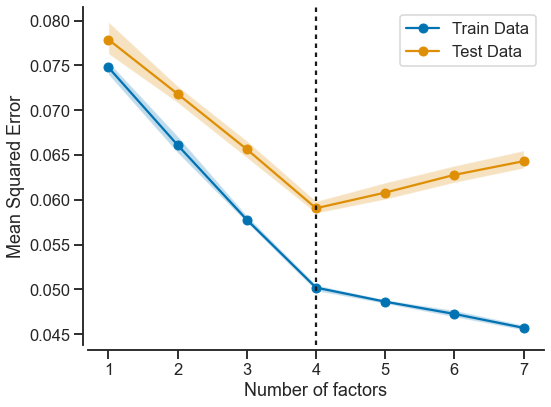

In [5]:
fig, ax = plt.subplots(1, figsize=(8, 6))

ax.plot(groups["MSE"]["mean"]["Train"], 'o-', label="Train Data")
ax.plot(groups["MSE"]["mean"]["Test"], 'o-', label="Test Data")

ax.fill_between(groups["MSE"]["5%"]["Train"].index, groups["MSE"]["5%"]["Train"], 
                groups["MSE"]["95%"]["Train"], alpha=0.25)
ax.fill_between(groups["MSE"]["5%"]["Test"].index, groups["MSE"]["5%"]["Test"],
                groups["MSE"]["95%"]["Test"], alpha=0.25)

inflection = (groups["MSE"]["mean"]["Test"] > groups["MSE"]["mean"]["Test"].shift()).idxmax() - 1

ax.axvline(inflection, color='k', dashes=[2, 2])

sns.despine(offset=5)
ax.set_ylabel("Mean Squared Error")
ax.set_xlabel("Number of factors")
ax.legend()
plt.tight_layout()

fig.savefig("Example 4 Factor Solution.png", dpi=350)

## The fun part - Let's try this on our Data

In [6]:
from nonnegfac.nnls import nnlsm_blockpivot as nnlstsq

def censored_nnlstsq(A, B, M):
    """Solves nonnegative least-squares problem with missing data in B
    Args
    ----
    A (ndarray) : m x r matrix
    B (ndarray) : m x n matrix
    M (ndarray) : m x n binary matrix (zeros indicate missing values)
    
    Returns
    -------
    X (ndarray) : nonnegative r x n matrix that minimizes norm(M*(AX - B))
    """
    if A.ndim == 1:
        A = A[:, None]
        
    rhs = np.dot(A.T, M * B).T[:, :, None] # n x r x 1 tensor
    T = np.matmul(A.T[None,:,:], M.T[:,:,None] * A[None,:,:]) # n x r x r tensor
    X = np.empty((B.shape[1], A.shape[1]))
    
    for n in range(B.shape[1]):
        X[n] = nnlstsq(T[n], rhs[n], is_input_prod=True)[0].T
    
    return X.T

def cv_nmf(data, rank, M=None, p_holdout=0.3, tol=0.001, verbose=False, max_iter=50):
    """Perform cross-validation for NMF using a speckled holdout pattern.
    
    This code was adapted from Alex Williams at Stanford (https://bit.ly/2KDqKoW).
    
    Args
    ----
    data (ndarray)    : m x n matrix (original data/time-series)
    rank (int)        : the desired output rank (i.e. number of factors)
    M (ndarray)       : m x n binary matrix where zeroes indicate missing/heldout values 
    p_holdout (float) : all random data under this value will be set to False
    tol (float)       : the tolerance for convergence - the solution has converged when 
                        the MSE of subsequent iterations are less than this number
    verbose (bool)    : if True, print out debugging information
    max_itr (int)     : the maximum number of iterations for convergence
    
    Returns
    -------
    U (ndarray)       : 
    Vt (ndarray)      :
    train_err (float) :
    test_err (float)  :
    converged (bool)  :
    
    """   
    # create the masking matrix to decide which values to "hold out"
    
    if M is None:
        M = np.random.rand(*data.shape) > p_holdout
        
        # check to make sure there are enough values in each row to avoid singular matrix issues
        # iterate over each row, and if the row contains less True values than rank
            # turn that row to all True values
        '''
        if M.sum(axis=0).any() < rank:
            for i in range(M.shape[0]):
                if M[i].sum() < rank:
                    M[i, :] = [True]*M.shape[1]
        '''
    # initialize U randomly
    U = np.random.rand(data.shape[0], rank)

    # init the mean err
    mse = 100
    
    # fit NMF
    for itr in range(max_iter):
        Vt = censored_nnlstsq(U, data, M)
        U = censored_nnlstsq(Vt.T, data.T, M.T).T
        
        # calculate the current iterations mean squared error
        tmp_mse = np.mean((np.dot(U, Vt) - data)**2)
        diff = mse - tmp_mse
          
        # break out of the loop if converged
        if abs(diff) <= tol:
            converged = True
            break
        else:
            mse = tmp_mse
            converged = False
    
    if verbose:
        train_pct = 100 * M.sum() / M.size
        print ("\tIter {} = {:.5f}".format(itr+1, diff))
        print ("\tTrain/Test = {:.2f}/{:.2f}".format(train_pct, 100-train_pct))
        
    # return the result and the train/test error
    resid = np.dot(U, Vt) - data
    train_err = np.mean(resid[M]**2)
    test_err = np.mean(resid[~M]**2)
        
    return U, Vt, train_err, test_err, converged

In [8]:
folder = '/Users/laurayang/Dropbox/Dr.Ng Group/Yang/Project2-LCS/B_Data-ES&T Roof/munged/NMF Raw-ARISense-Data/interpolated-raw-gas/'
input_file = folder + '5-merged-timeseries-6min.csv'

df = pd.read_csv(input_file).set_index("timestamp")

COLS_TO_INCLUDE = ['co', 'no2', 'o3', 'no', 'bin0', 'bin1', 'bin2']

df = df.dropna(subset=COLS_TO_INCLUDE)[COLS_TO_INCLUDE].sample(frac=0.15)
'''
#df = df / df.max().max()
def maximum_absolute_scaling_particle(df):
    # copy the dataframe
    df_scaled = df.copy()
    # apply maximum absolute scaling
    for column in ['bin0','bin1','bin2']:
        df_scaled[column] = df_scaled[column] / (df['bin0'].max())
    return df_scaled

def maximum_absolute_scaling_gas(df):
    # copy the dataframe
    df_scaled = df.copy()
    # apply maximum absolute scaling
    for column in ['co','no','no2','o3']:
        df_scaled[column] = df_scaled[column] / (df['co'].max())
    return df_scaled

# call the maximum_absolute_scaling function
df_normalized_particle = maximum_absolute_scaling_particle(df)
df_normalized_both = maximum_absolute_scaling_gas(df_normalized_particle)
'''

def maximum_absolute_scaling(df):
    # copy the dataframe
    df_scaled = df.copy()
    # apply maximum absolute scaling
    for column in df_scaled.columns:
        df_scaled[column] = df_scaled[column]  / df_scaled[column].abs().max()
    return df_scaled
   
# call the maximum_absolute_scaling function
df = maximum_absolute_scaling(df)

df_normalized_both.head(2)

,co,no2,o3,no,bin0,bin1,bin2
timestamp,,,,,,,
2020-12-05 19:54:00-05:00,0.121978,0.006877,0.045403,0.002054,0.247211,0.022486,0.005284
2020-12-09 21:24:00-05:00,0.200131,0.015124,0.034149,0.018280,0.287678,0.041160,0.013980


In [13]:
replicates = 10

ranks = np.arange(1, 7)

frame = pd.DataFrame()

# fit the models
for rnk, j in itertools.product(ranks, range(replicates)):
    print ("Rank {}.{}".format(rnk, j))
    
    tr, te, converged = cv_nmf(df_normalized_both.values, rnk, verbose=True, tol=1e-3, max_iter=200, p_holdout=0.3)[2:]
    
    if not converged:
        print ("there was a convergence issue: {}".format(rnk))
    frame = frame.append([
        {"Rank": rnk, "MSE": tr, "Group": "Train", "Converged": converged},
        {"Rank": rnk, "MSE": te, "Group": "Test", "Converged": converged},
    ], ignore_index=True)

frame["Rank"] = frame["Rank"].astype(np.int32)

# prepare for plotting
groups = frame.groupby(["Group", "Rank"]).describe(percentiles=[0.05, 0.95])

Rank 1.0
	Iter 2 = -0.00005
	Train/Test = 69.97/30.03
Rank 1.1
	Iter 2 = 0.00001
	Train/Test = 70.38/29.62
Rank 1.2
	Iter 2 = 0.00003
	Train/Test = 69.72/30.28
Rank 1.3
	Iter 2 = -0.00006
	Train/Test = 69.17/30.83
Rank 1.4
	Iter 2 = -0.00000
	Train/Test = 69.18/30.82
Rank 1.5
	Iter 2 = -0.00005
	Train/Test = 70.83/29.17
Rank 1.6
	Iter 2 = -0.00005
	Train/Test = 69.83/30.17
Rank 1.7
	Iter 2 = -0.00005
	Train/Test = 69.59/30.41
Rank 1.8
	Iter 2 = -0.00004
	Train/Test = 70.03/29.97
Rank 1.9
	Iter 2 = 0.00003
	Train/Test = 69.40/30.60
Rank 2.0
	Iter 2 = 0.00062
	Train/Test = 69.98/30.02
Rank 2.1
	Iter 2 = 0.00069
	Train/Test = 70.03/29.97
Rank 2.2
	Iter 2 = 0.00059
	Train/Test = 69.98/30.02
Rank 2.3
	Iter 2 = 0.00030
	Train/Test = 69.62/30.38
Rank 2.4
	Iter 2 = 0.00015
	Train/Test = 70.19/29.81
Rank 2.5
	Iter 2 = -0.00031
	Train/Test = 70.36/29.64
Rank 2.6
	Iter 2 = 0.00050
	Train/Test = 69.37/30.63
Rank 2.7
	Iter 2 = 0.00078
	Train/Test = 70.03/29.97
Rank 2.8
	Iter 2 = 0.00056
	Train/Test

In [10]:
groups

MSE                                                              \
           count      mean       std       min        5%       50%       95%   
Group Rank                                                                     
Test  1     10.0  0.005327  0.000572  0.004553  0.004649  0.005216  0.006172   
      2     10.0  0.005171  0.001649  0.003254  0.003576  0.004427  0.007675   
      3     10.0  0.004727  0.001381  0.003320  0.003415  0.004086  0.007109   
      4     10.0  0.004196  0.000895  0.003331  0.003355  0.003974  0.005642   
      5     10.0  0.004867  0.001593  0.003302  0.003365  0.004278  0.007633   
      6     10.0  0.003603  0.000657  0.002768  0.002851  0.003457  0.004751   
      7     10.0  0.005060  0.002494  0.003005  0.003215  0.004587  0.008835   
Train 1     10.0  0.000905  0.000052  0.000835  0.000844  0.000890  0.000978   
      2     10.0  0.000391  0.000105  0.000317  0.000321  0.000355  0.000568   
      3     10.0  0.000281  0.000055  0.000142  0.000195  0.000295  0.000325   
      4     10.0  0.000206  0.000028  0.000141  0.000163  0.000212  0.000238   
      5     10.0  0.000179  0.000041  0.000081  0.000114  0.000183  0.000220   
      6     10.0  0.000143  0.000024  0.000100  0.000109  0.000141  0.000174   
      7     10.0  0.000120  0.000035  0.000052  0.000065  0.000123  0.000165   

                      
                 max  
Group Rank            
Test  1     0.006179  
      2     0.008392  
      3     0.007326  
      4     0.006467  
      5     0.007846  
      6     0.004794  
      7     0.011884  
Train 1     0.000996  
      2     0.000664  
      3     0.000326  
      4     0.000244  
      5     0.000227  
      6     0.000174  
      7     0.000175

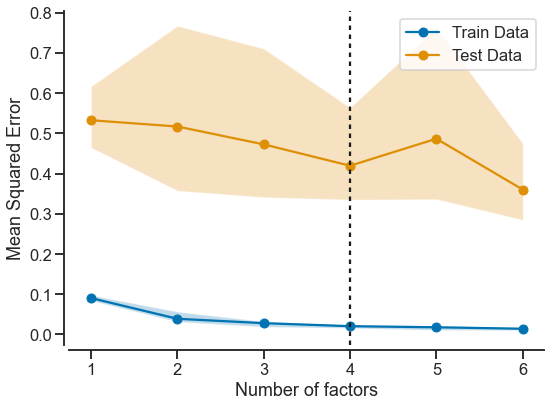

In [11]:
fig, ax = plt.subplots(1, figsize=(8, 6))

scalar = 100

ax.plot(groups["MSE"]["mean"]["Train"][:-1]*scalar, 'o-', label="Train Data")
ax.plot(groups["MSE"]["mean"]["Test"][:-1]*scalar, 'o-', label="Test Data")

ax.fill_between(groups["MSE"]["5%"]["Train"].index[:-1], groups["MSE"]["5%"]["Train"][:-1]*scalar, 
                groups["MSE"]["95%"]["Train"][:-1]*scalar, alpha=0.25)
ax.fill_between(groups["MSE"]["5%"]["Test"].index[:-1], groups["MSE"]["5%"]["Test"][:-1]*scalar,
                groups["MSE"]["95%"]["Test"][:-1]*scalar, alpha=0.25)

inflection = (groups["MSE"]["mean"]["Test"] > groups["MSE"]["mean"]["Test"].shift()).idxmax() - 1
ax.axvline(inflection, color='k', dashes=[2, 2])

sns.despine(offset=5)
ax.set_ylabel("Mean Squared Error")
ax.set_xlabel("Number of factors")
ax.legend()
plt.tight_layout()

ax.set_xticks([1, 2, 3, 4, 5, 6])
ax.set_xticklabels([1, 2, 3, 4, 5, 6])

folder = '/Users/laurayang/Desktop/ProjecNMF/Fig_used_in_paper/'
fig.savefig(folder+"9_CV_1e-3-max_iter200_original.png", dpi=350)
